# Klasifikace zvukových záznamů
Zadání: Ve zdrojové databázi najdete celkem 208 hlasových záznamů písmene a. Pomocí Vámi vybrané
techniky v časové nebo frekvenční oblasti klasifikujte zvukové záznamy na dobré a patologické.
V případě patologických poté klasifikujte jednotlivé poruchy. Jejich výčet najdete buď
v hlavičkových souborech nebo v propisu databáze. Pro klasifikaci do jednotlivých skupin
použijte veškeré techniky, které jste si v rámci kurzu osvojili včetně Fourierovy a kepstrální
analýzy. Úspěšnost Vašeho postupu porovnejte s anotacemi, resp. rozřazením do skupin, které
provedli experti, kteří data pořizovali.

In [3]:
import pandas as pd
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import *
import os
import re

In [29]:
# Získání seznamu všech souborů ve složce
def list_files(path):
    files = os.listdir(path)
    hea_files = [f for f in files if f.endswith(".hea")]
    return hea_files


def extract_audio_metadata(record_name: str) -> pd.DataFrame:
    """
    Načte záznam hlasového signálu a extrahuje metadata.
    """
    record = wfdb.rdrecord(record_name)
        
    # Vytvoření tabulky s metadaty
    data = [
        ["Název souboru", record.record_name],  # Název souboru
        ["Vzorkovací frekvence (Hz)", record.fs],  # Vzorkovací frekvence
        ["Délka signálu (vzorky)", record.sig_len],  # Délka signálu (počet vzorků)
        ["Počet kanálů", record.n_sig],  # Počet kanálů
        ["Názvy kanálů", ", ".join(record.sig_name)],  # Názvy kanálů
        ["Jednotky", ", ".join(record.units)]  # Jednotky měření
        ]
        
        # Vytvoření DataFrame
    df = pd.DataFrame(data, columns=["Informace", "Hodnota"])

    return df

def load_voice_signal(record_name: str):
    """
    Načte hlasový signál a vrátí jeho vzorky a vzorkovací frekvenci.
    """

    record = wfdb.rdrecord(record_name)
    voice_signal = record.p_signal[:, 0]  # První kanál signálu
    fs = record.fs  # Vzorkovací frekvence
    
    return voice_signal, fs  
   
  

def plot_voice_signal(voice_signal, fs, title="Hlasový signál", figsize=(10, 4)):
    """
    Vykreslí časový průběh hlasového signálu.
    """
    if voice_signal is None or fs is None:
        print("Chyba: Neplatná data signálu.")
        return
    
    time = np.arange(len(voice_signal)) / fs  # Generování časové osy
    plt.figure(figsize=figsize)
    plt.plot(time, voice_signal, color="blue")
    plt.xlabel("Čas (sekundy)")
    plt.ylabel("Amplituda")
    plt.title(title)
    plt.grid()
    plt.show()


def extract_unique_diagnoses(data_path):
    """
    Prohledá všechny soubory -info.txt ve složce a extrahuje unikátní diagnózy
    bez textu ve skobkách.
    """
    diagnoses = []
    
    for file in os.listdir(data_path):
        if file.endswith("-info.txt"):
            with open(os.path.join(data_path, file), "r", encoding="utf-8") as f:
                for line in f:
                    if "Diagnosis:" in line:
                        diagnosis = line.split("Diagnosis:")[1].strip()
                        
                        diagnosis_clean = re.sub(r"\s*\(.*?\)", "", diagnosis).strip()
                        
                        # Přidáme pouze unikátní hodnoty
                        if diagnosis_clean not in diagnoses:
                            diagnoses.append(diagnosis_clean)
    
    return diagnoses


def get_files_by_diagnosis(data_path, target_diagnoses):
    """
    Prohledá všechny soubory -info.txt ve složce a vypíše názvy souborů,
    které obsahují zadané diagnózy.
    """
    diagnosis_files = {diag: [] for diag in target_diagnoses}  
    
    for file in os.listdir(data_path):
        if file.endswith("-info.txt"):
            file_path = os.path.join(data_path, file)
            
            with open(file_path, "r", encoding="utf-8") as f:
                for line in f:
                    if "Diagnosis:" in line:
                        diagnosis = line.split("Diagnosis:")[1].strip()
                        
                        # Odebereme část v závorkách
                        diagnosis_clean = re.sub(r"\s*\(.*?\)", "", diagnosis).strip()
                        
                        if diagnosis_clean in target_diagnoses:
                            file_base = file.replace("-info.txt", "")  # Název souboru bez přípony
                            diagnosis_files[diagnosis_clean].append(file_base)
    
    return diagnosis_files


def compute_fft_features(signal, fs=8000):  #Frekvence je ve všech souborech stejná (8000)
    """
    Vypočítá FFT signálu a vrátí frekvence, amplitudu a počet vzorků.
    """
    N = len(signal)
    fft_result = np.fft.rfft(signal)
    magnitude = np.abs(fft_result)
    freqs = np.fft.rfftfreq(N, d=1/fs)

    return fft_result, magnitude, freqs, N

    
def plot_frequency_spectrum(freqs, magnitude, title="Frekvenční spektrum", figsize=(10, 4)):
    """
    Vykreslí frekvenční spektrum signálu.
    """   
    plt.figure(figsize=figsize)
    plt.plot(freqs, magnitude, color="blue")
    plt.xlabel("Frekvence (Hz)")
    plt.ylabel("Amplituda")
    plt.title(title)
    plt.grid()
    plt.show()


def compute_spectral_features(magnitude, freqs):
    """
    Vypočítá základní spektrální parametry: centroid, spread, skewness, entropy.
    """
    # Normujeme spektrum, aby mělo součet 1 (pravděpodobnostní rozdělení)
    magnitude_norm = magnitude / np.sum(magnitude)

    # Spektrální centroid (středová frekvence)
    centroid = np.sum(freqs * magnitude_norm)

    # Spektrální šířka (spread)
    spread = np.sqrt(np.sum(((freqs - centroid) ** 2) * magnitude_norm))

    # Spektrální sklon (skewness) - ukazuje, jestli je spektrum posunuto vlevo/vpravo
    skewness = np.sum(((freqs - centroid) ** 3) * magnitude_norm) / (spread ** 3)

    # Spektrální entropie - ukazuje, jak moc je spektrum rovnoměrné
    entropy = -np.sum(magnitude_norm * np.log2(magnitude_norm + 1e-12))  # Přidáme epsilon pro stabilitu

    return {
        "Spektrální centroid (Hz)": centroid,
        "Spektrální šířka (Hz)": spread,
        "Spektrální sklon": skewness,
        "Spektrální entropie": entropy
    }


def analyze_peak_features(magnitude, freqs, prominence=0.1, height_ratio=0.2):
    """
    Analyzuje hlavní frekvence a pravidelnost spektra.
    """
    # Hledání píků na základě výšky a prominence
    peaks, _ = find_peaks(magnitude, height=np.max(magnitude) * height_ratio, prominence=prominence)

    if len(peaks) == 0:
        return 0, 1, 0, []  # Pokud nejsou žádné výrazné vrcholy

    # Získání hlavních frekvencí z indexů píků
    peak_frequencies = freqs[peaks]

    # Hlavní frekvence (F0) - první výrazný pík
    f0 = peak_frequencies[0]

    # Pravidelnost harmonických - rozptyl rozdílů mezi harmonickými
    harmonic_intervals = np.diff(peak_frequencies)  # Rozdíly mezi sousedními frekvencemi
    harmonic_regularity = np.std(harmonic_intervals) if len(harmonic_intervals) > 1 else 0

    # Variabilita F0 - celkový rozptyl nalezených hlavních frekvencí
    fundamental_freq_variability = np.std(peak_frequencies) if len(peak_frequencies) > 1 else 0

    return f0, harmonic_regularity, fundamental_freq_variability, peak_frequencies



def compute_cepstrum_from_fft(fft_result):
    """
    Vypočítá kepstrum na základě FFT signálu.
    """
    # Převod FFT spektra na logaritmickou stupnici
    log_spectrum = np.log(np.abs(fft_result) + 1e-10)  # Přidání malé hodnoty pro stabilitu

    # Výpočet kepstra inverzní FFT
    cepstrum = np.fft.irfft(log_spectrum)

    return cepstrum


def compute_cepstral_features(fft_result, magnitude, freqs, N, cepstrum ):
    """
    Vypočítá hlavní kepstrální parametry: kepstrální vrchol (CPP), průměrnou hodnotu kepstra (CEPS-Mean)
    """

    # Hledání maxima v kepstru (CPP - Cepstral Peak Prominence)
    cpp_index = np.argmax(cepstrum[1:]) + 1  # Hledáme od druhého prvku
    cpp_value = cepstrum[cpp_index]

    # Průměrná hodnota kepstra (CEPS-Mean)
    ceps_mean = np.mean(cepstrum)
    return {
        "Kepstrální vrchol (CPP)": cpp_value,
        "Průměrná hodnota kepstra (CEPS-Mean)": ceps_mean
    }


def is_voice_healthy(signal, fs=8000):
    """
    Ověří, zda je hlas zdravý na základě spektrálních a kepstrálních rysů.
    """

    # Výpočet FFT
    fft_result, magnitude, freqs, n = compute_fft_features(signal, fs)

    # Výpočet kepstra
    cepstrum = compute_cepstrum_from_fft(fft_result)

    # Výpočet spektrálních rysů
    spectral_features = compute_spectral_features(magnitude, freqs)

    # Výpočet kepstrálních rysů
    cepstral_features = compute_cepstral_features(fft_result, magnitude, freqs, n, cepstrum)

    # prahové hodnoty pro zdravý hlas
    cpp_threshold = 0.4                      # kepstrální vrchol musí být dostatečně výrazný
    ceps_mean_threshold = 0.00007            # průměrná hodnota kepstra by měla být nízká
    entropy_threshold = 6.5                  # entropie 
    centroid_min, centroid_max = 1100, 1800  # středová frekvence spektra
    spread_threshold = 800                   # spektrální šířka by neměla být příliš vysoká
    skewness_threshold = 1.5                 # spektrum by nemělo být příliš asymetrické

    # Získání hodnot z analýzy
    cpp_value = cepstral_features["Kepstrální vrchol (CPP)"]
    ceps_mean = cepstral_features["Průměrná hodnota kepstra (CEPS-Mean)"]
    entropy = spectral_features["Spektrální entropie"]

    spectral_centroid = spectral_features["Spektrální centroid (Hz)"]
    spectral_spread = spectral_features["Spektrální šířka (Hz)"]
    spectral_skewness = spectral_features["Spektrální sklon"]

    f0, harmonic_regularity, fundamental_freq_variability, _ = analyze_peak_features(magnitude, freqs)

    #  Definování podmínek pro zdravý hlas
    conditions = [
        cpp_value > cpp_threshold,
        ceps_mean < ceps_mean_threshold,
        entropy < entropy_threshold,
        centroid_min < spectral_centroid < centroid_max,
        spectral_spread < spread_threshold,
        abs(spectral_skewness) < skewness_threshold
    ]

    # Rozhodnutí na základě počtu splněných podmínek
    required_conditions = 5  # minimálně 5 z 6 podmínek musí být splněno
    return sum(conditions) >= required_conditions



def evaluate_voice_data(directory):
    """
    Analyzuje všechny soubory v adresáři a vytvoří tabulku s úspěšností predikce.
    """

    diagnoses = extract_unique_diagnoses(directory)
    diagnosis_files = get_files_by_diagnosis(directory, diagnoses)

    correct = 0
    wrong = 0
    total = 0

    for filename in os.listdir(directory):
        if filename.endswith(".dat"): 
            record_name = filename.replace(".dat", "")  
            record_path = os.path.join(directory, record_name)  

            if not os.path.exists(f"{record_path}.hea") or not os.path.exists(f"{record_path}.dat"):
                print(f"Soubor {record_path}.hea nebo {record_path}.dat nebyl nalezen, přeskočeno.")
                continue

            for diagnosis, files in diagnosis_files.items():
                if record_name in files:
                    true_healthy = (diagnosis.lower() == "healthy")  

                    try:
                        voice_signal, fs = load_voice_signal(record_path)
                        predicted_healthy = is_voice_healthy(voice_signal, fs)

                        if predicted_healthy == true_healthy:
                            correct += 1
                        else:
                            wrong += 1

                        total += 1
                    except Exception as e:
                        print(f"Chyba při zpracování souboru {record_path}: {e}")

    success_rate = (correct / total) * 100 if total > 0 else 0

    results_df = pd.DataFrame({
        "Correct": [correct],
        "Wrong": [wrong],
        "Total": [total],
        "Success Rate (%)": [success_rate]
    })


    return results_df


            


In [5]:
data_path = "voice-icar-federico-ii-database-1.0.0"

files = list_files(data_path)
print(f"Nalezeno {len(files)} .hea souborů")
    


Nalezeno 208 .hea souborů


In [6]:
record_name = "voice-icar-federico-ii-database-1.0.0/voice001"

extract_audio_metadata(record_name)


,Informace,Hodnota
0,Název souboru,voice001
1,Vzorkovací frekvence (Hz),8000
2,Délka signálu (vzorky),38080
3,Počet kanálů,1
4,Názvy kanálů,voice
5,Jednotky,NU


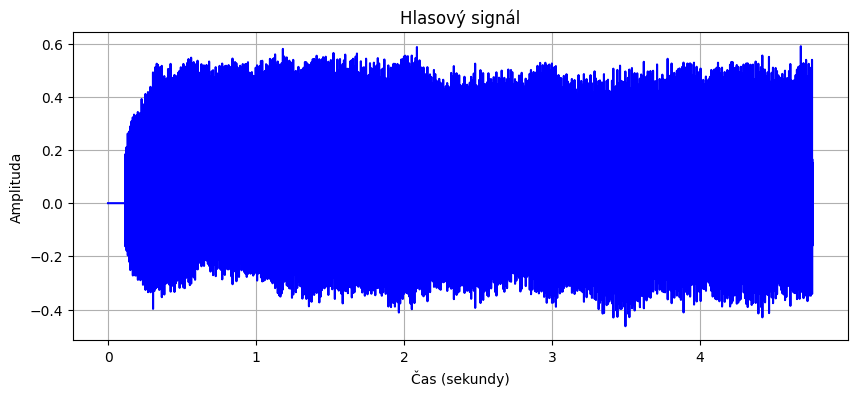

In [7]:
voice_signal, fs  = load_voice_signal(record_name)

plot_voice_signal(voice_signal, fs)

In [8]:
diagnoses = extract_unique_diagnoses(data_path)
diagnoses

['healthy',
 'hyperkinetic dysphonia',
 'reflux laryngitis',
 'hypokinetic dysphonia']

In [9]:
diagnosis_files = get_files_by_diagnosis(data_path, diagnoses)
for diagnosis, files in diagnosis_files.items():
    print(f" Diagnóza: {diagnosis}")
    print(f"Soubory: {', '.join(files) if files else 'Žádné soubory nenalezeny'}")
    print("-" * 50)

 Diagnóza: healthy
Soubory: voice100, voice101, voice040, voice177, voice176, voice002, voice090, voice091, voice134, voice184, voice123, voice204, voice158, voice051, voice110, voice111, voice182, voice183, voice019, voice125, voice203, voice195, voice107, voice139, voice097, voice096, voice085, voice120, voice207, voice061, voice060, voice206, voice114, voice115, voice049, voice092, voice109, voice108, voice103, voice102, voice099, voice098, voice034, voice095, voice179, voice178, voice070, voice196, voice197, voice104, voice045, voice032, voice067, voice181, voice180, voice025, voice024
--------------------------------------------------
 Diagnóza: hyperkinetic dysphonia
Soubory: voice192, voice193, voice009, voice149, voice143, voice003, voice198, voice199, voice185, voice117, voice068, voice160, voice021, voice020, voice129, voice128, voice086, voice155, voice205, voice159, voice018, voice167, voice166, voice208, voice188, voice080, voice153, voice152, voice064, voice194, voice138,

In [10]:
record_name_healthy = 'voice-icar-federico-ii-database-1.0.0/voice100'
healthy_voice_signal, healthy_fs  = load_voice_signal(record_name_healthy)

record_name_hyperkinetic_dysphonia = 'voice-icar-federico-ii-database-1.0.0/voice192'
hyperkinetic_dysphonia_voice_signal, hyperkinetic_dysphonia_fs  = load_voice_signal(record_name_hyperkinetic_dysphonia)

record_name_reflux_laryngitis = 'voice-icar-federico-ii-database-1.0.0/voice008'
reflux_laryngitis_voice_signal, reflux_laryngitis_fs  = load_voice_signal(record_name_reflux_laryngitis)

record_name_hypokinetic_dysphonia= 'voice-icar-federico-ii-database-1.0.0/voice036'
hypokinetic_dysphonia_voice_signal, hypokinetic_dysphonia_fs  = load_voice_signal(record_name_hypokinetic_dysphonia)

In [12]:
print(extract_audio_metadata(record_name_healthy))
print(extract_audio_metadata(record_name_hyperkinetic_dysphonia))
print(extract_audio_metadata(record_name_reflux_laryngitis))
print(extract_audio_metadata(record_name_hypokinetic_dysphonia))

                   Informace   Hodnota
0              Název souboru  voice100
1  Vzorkovací frekvence (Hz)      8000
2     Délka signálu (vzorky)     38080
3               Počet kanálů         1
4               Názvy kanálů     voice
5                   Jednotky        NU
                   Informace   Hodnota
0              Název souboru  voice192
1  Vzorkovací frekvence (Hz)      8000
2     Délka signálu (vzorky)     38080
3               Počet kanálů         1
4               Názvy kanálů     voice
5                   Jednotky        NU
                   Informace   Hodnota
0              Název souboru  voice008
1  Vzorkovací frekvence (Hz)      8000
2     Délka signálu (vzorky)     38080
3               Počet kanálů         1
4               Názvy kanálů     voice
5                   Jednotky        NU
                   Informace   Hodnota
0              Název souboru  voice036
1  Vzorkovací frekvence (Hz)      8000
2     Délka signálu (vzorky)     37760
3               Počet kan

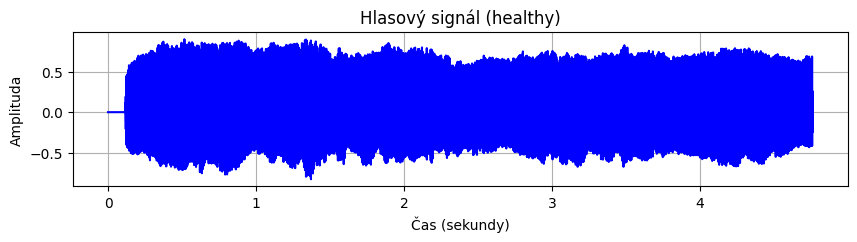

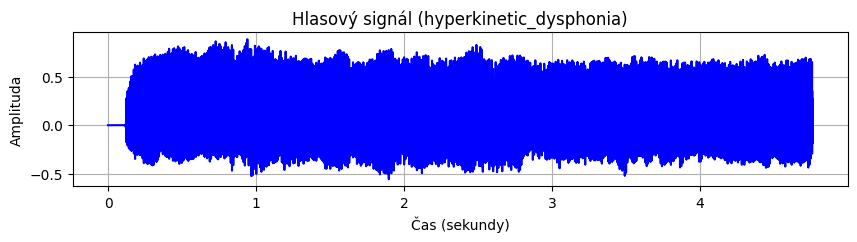

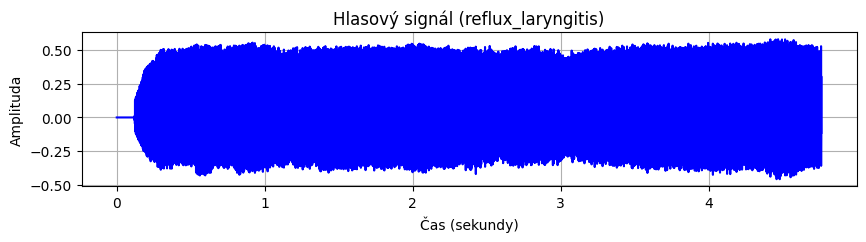

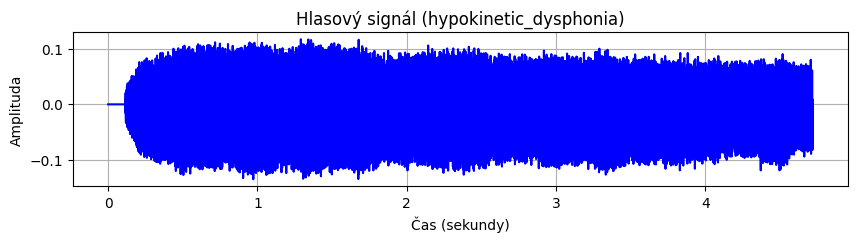

In [13]:
plot_voice_signal(healthy_voice_signal, healthy_fs, title="Hlasový signál (healthy)", figsize=(10, 2))
plot_voice_signal(hyperkinetic_dysphonia_voice_signal, hyperkinetic_dysphonia_fs, title="Hlasový signál (hyperkinetic_dysphonia)", figsize=(10, 2))
plot_voice_signal(reflux_laryngitis_voice_signal, reflux_laryngitis_fs , title="Hlasový signál (reflux_laryngitis)", figsize=(10, 2))
plot_voice_signal(hypokinetic_dysphonia_voice_signal, hypokinetic_dysphonia_fs , title="Hlasový signál (hypokinetic_dysphonia)", figsize=(10, 2))

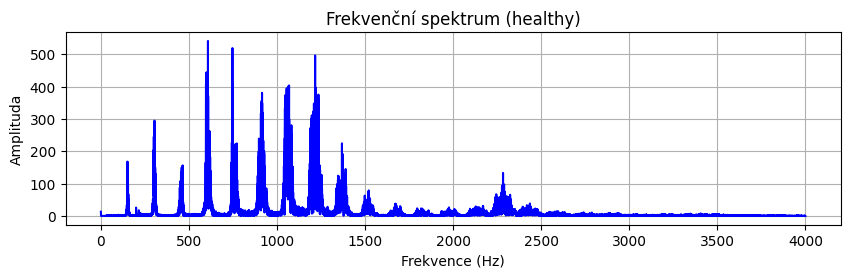

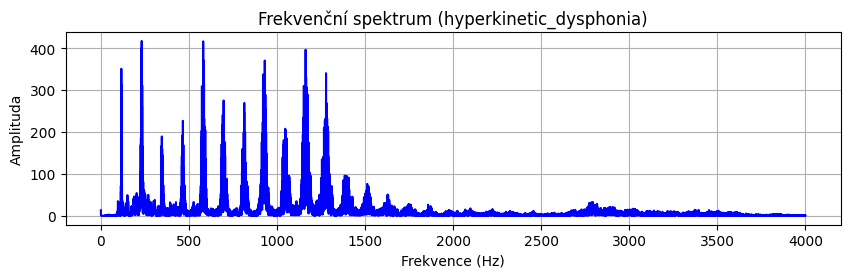

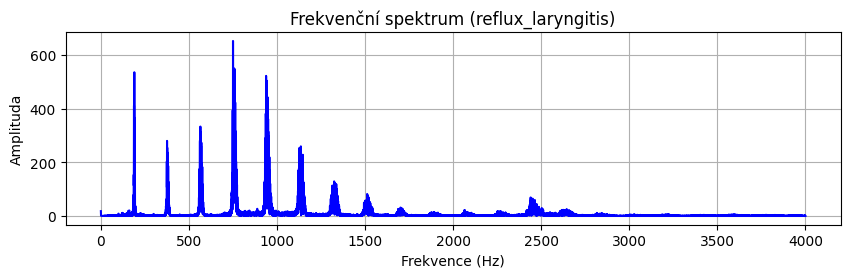

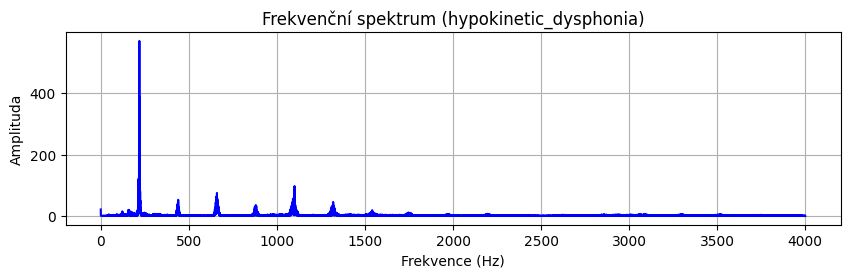

In [14]:
# healthy
fft_result, magnitude, freqs, N = compute_fft_features(healthy_voice_signal)
plot_frequency_spectrum(freqs, magnitude,title="Frekvenční spektrum (healthy)", figsize=(10,2.5))

# hyperkinetic_dysphonia
fft_result, magnitude, freqs, N  = compute_fft_features(hyperkinetic_dysphonia_voice_signal)
plot_frequency_spectrum(freqs, magnitude,title="Frekvenční spektrum (hyperkinetic_dysphonia)", figsize=(10,2.5))

# reflux_laryngitis
fft_result, magnitude, freqs, N  = compute_fft_features(reflux_laryngitis_voice_signal)
plot_frequency_spectrum(freqs, magnitude,title="Frekvenční spektrum (reflux_laryngitis)", figsize=(10,2.5))

# hypokinetic_dysphonia
fft_result, magnitude, freqs, N  = compute_fft_features(hypokinetic_dysphonia_voice_signal)
plot_frequency_spectrum(freqs, magnitude,title="Frekvenční spektrum (hypokinetic_dysphonia)", figsize=(10,2.5))

In [15]:
# healthy
fft_result, magnitude, freqs, N = compute_fft_features(healthy_voice_signal)
spectral_features_healthy = compute_spectral_features(magnitude, freqs)
print(f'healthy : {spectral_features_healthy}')

# hyperkinetic_dysphonia
fft_result, magnitude, freqs, N  = compute_fft_features(hyperkinetic_dysphonia_voice_signal)
spectral_features_hyperkinetic_dysphonia = compute_spectral_features(magnitude, freqs)
print(f'hyperkinetic_dysphonia : {spectral_features_hyperkinetic_dysphonia}')

# reflux_laryngitis
fft_result, magnitude, freqs, N  = compute_fft_features(reflux_laryngitis_voice_signal)
spectral_features_reflux_laryngitis = compute_spectral_features(magnitude, freqs)
print(f'reflux_laryngitis : {spectral_features_reflux_laryngitis}')

# hypokinetic_dysphonia
fft_result, magnitude, freqs, N  = compute_fft_features(hypokinetic_dysphonia_voice_signal)
spectral_features_hypokinetic_dysphonia= compute_spectral_features(magnitude, freqs)
print(f'hypokinetic_dysphonia : {spectral_features_hypokinetic_dysphonia}')


healthy : {'Spektrální centroid (Hz)': 1232.2230328057797, 'Spektrální šířka (Hz)': 663.8769784757255, 'Spektrální sklon': 1.2120260129049363, 'Spektrální entropie': 12.225332327812122}
hyperkinetic_dysphonia : {'Spektrální centroid (Hz)': 1192.2407968657556, 'Spektrální šířka (Hz)': 805.1882953969368, 'Spektrální sklon': 1.302541916710064, 'Spektrální entropie': 12.71494149829967}
reflux_laryngitis : {'Spektrální centroid (Hz)': 1187.5037455783458, 'Spektrální šířka (Hz)': 754.8327490015514, 'Spektrální sklon': 1.3120603705289706, 'Spektrální entropie': 11.910038134618905}
hypokinetic_dysphonia : {'Spektrální centroid (Hz)': 1298.4858298911097, 'Spektrální šířka (Hz)': 1064.6830574717917, 'Spektrální sklon': 0.9068673210980888, 'Spektrální entropie': 12.53462955938896}


In [16]:
# healthy
fft_result, magnitude, freqs, N = compute_fft_features(healthy_voice_signal)
spectral_features_healthy = compute_spectral_features(magnitude, freqs)
f0, harmonic_regularity, freq_variability, peak_frequencies = analyze_peak_features(magnitude, freqs)
print(f"healthy \nZákladní frekvence (F0): {f0:.2f} Hz")
print(f"Pravidelnost harmonických: {harmonic_regularity:.2f}")
print(f"Variabilita základní frekvence: {freq_variability:.2f}")
#print(f"Hlavní frekvence: {peak_frequencies}")


# hyperkinetic_dysphonia
fft_result, magnitude, freqs, N  = compute_fft_features(hyperkinetic_dysphonia_voice_signal)
spectral_features_hyperkinetic_dysphonia = compute_spectral_features(magnitude, freqs)
f0, harmonic_regularity, freq_variability, peak_frequencies = analyze_peak_features(magnitude, freqs)
print(f"\nhyperkinetic_dysphonia \nZákladní frekvence (F0): {f0:.2f} Hz")
print(f"Pravidelnost harmonických: {harmonic_regularity:.2f}")
print(f"Variabilita základní frekvence: {freq_variability:.2f}")

# reflux_laryngitis
fft_result, magnitude, freqs, N  = compute_fft_features(reflux_laryngitis_voice_signal)
spectral_features_reflux_laryngitis = compute_spectral_features(magnitude, freqs)
f0, harmonic_regularity, freq_variability, peak_frequencies = analyze_peak_features(magnitude, freqs)
print(f"\nreflux_laryngitis \nZákladní frekvence (F0): {f0:.2f} Hz")
print(f"Pravidelnost harmonických: {harmonic_regularity:.2f}")
print(f"Variabilita základní frekvence: {freq_variability:.2f}")

# hypokinetic_dysphonia
fft_result, magnitude, freqs, N  = compute_fft_features(hypokinetic_dysphonia_voice_signal)
spectral_features_hypokinetic_dysphonia= compute_spectral_features(magnitude, freqs)
f0, harmonic_regularity, freq_variability, peak_frequencies = analyze_peak_features(magnitude, freqs)
print(f"\nhypokinetic_dysphonia \nZákladní frekvence (F0): {f0:.2f} Hz")
print(f"Pravidelnost harmonických: {harmonic_regularity:.2f}")
print(f"Variabilita základní frekvence: {freq_variability:.2f}")

healthy 
Základní frekvence (F0): 149.37 Hz
Pravidelnost harmonických: 50.37
Variabilita základní frekvence: 315.43

hyperkinetic_dysphonia 
Základní frekvence (F0): 114.92 Hz
Pravidelnost harmonických: 14.85
Variabilita základní frekvence: 340.12

reflux_laryngitis 
Základní frekvence (F0): 186.13 Hz
Pravidelnost harmonických: 30.27
Variabilita základní frekvence: 259.56

hypokinetic_dysphonia 
Základní frekvence (F0): 215.68 Hz
Pravidelnost harmonických: 0.22
Variabilita základní frekvence: 2.03


In [17]:
# healthy
fft_result, magnitude, freqs, N = compute_fft_features(healthy_voice_signal)
cepstrum = compute_cepstrum_from_fft(fft_result)
print('\nhealthy')
print(compute_cepstral_features(fft_result, magnitude, freqs, N, cepstrum ))

# hyperkinetic_dysphonia
fft_result, magnitude, freqs, N  = compute_fft_features(hyperkinetic_dysphonia_voice_signal)
cepstrum = compute_cepstrum_from_fft(fft_result)
print('\nhyperkinetic_dysphonia')
print(compute_cepstral_features(fft_result, magnitude, freqs, N, cepstrum ))

# reflux_laryngitis
fft_result, magnitude, freqs, N  = compute_fft_features(reflux_laryngitis_voice_signal)
cepstrum = compute_cepstrum_from_fft(fft_result)
print('\nreflux_laryngitis')
print(compute_cepstral_features(fft_result, magnitude, freqs, N, cepstrum ))


# hypokinetic_dysphonia
fft_result, magnitude, freqs, N  = compute_fft_features(hypokinetic_dysphonia_voice_signal)
cepstrum = compute_cepstrum_from_fft(fft_result)
print('\nhypokinetic_dysphonia')
print(compute_cepstral_features(fft_result, magnitude, freqs, N, cepstrum ))




healthy
{'Kepstrální vrchol (CPP)': 0.4698635190583461, 'Průměrná hodnota kepstra (CEPS-Mean)': 6.758879894261984e-05}

hyperkinetic_dysphonia
{'Kepstrální vrchol (CPP)': 0.46849538432126037, 'Průměrná hodnota kepstra (CEPS-Mean)': 6.875924078725585e-05}

reflux_laryngitis
{'Kepstrální vrchol (CPP)': 0.4458947045596854, 'Průměrná hodnota kepstra (CEPS-Mean)': 7.595083791840906e-05}

hypokinetic_dysphonia
{'Kepstrální vrchol (CPP)': 0.2023185086793501, 'Průměrná hodnota kepstra (CEPS-Mean)': 8.087600510342135e-05}


In [24]:
record_name_healthy = 'voice-icar-federico-ii-database-1.0.0/voice100'
healthy_voice_signal, healthy_fs  = load_voice_signal(record_name_healthy)

record_name_hyperkinetic_dysphonia = 'voice-icar-federico-ii-database-1.0.0/voice192'
hyperkinetic_dysphonia_voice_signal, hyperkinetic_dysphonia_fs  = load_voice_signal(record_name_hyperkinetic_dysphonia)

record_name_reflux_laryngitis = 'voice-icar-federico-ii-database-1.0.0/voice008'
reflux_laryngitis_voice_signal, reflux_laryngitis_fs  = load_voice_signal(record_name_reflux_laryngitis)

record_name_hypokinetic_dysphonia= 'voice-icar-federico-ii-database-1.0.0/voice036'
hypokinetic_dysphonia_voice_signal, hypokinetic_dysphonia_fs  = load_voice_signal(record_name_hypokinetic_dysphonia)



print(is_voice_healthy(healthy_voice_signal))
print(is_voice_healthy(hyperkinetic_dysphonia_voice_signal))
print(is_voice_healthy(reflux_laryngitis_voice_signal))
print(is_voice_healthy(hypokinetic_dysphonia_voice_signal))

True
False
False
False


In [28]:
directory = "voice-icar-federico-ii-database-1.0.0"
evaluate_voice_data(directory)

,Correct,Wrong,Total,Success Rate (%)
0,140,68,208,67.307692
